In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from etransportmodel.trip_data import TripData
from etransportmodel.charging_choice import ChargingChoice
from etransportmodel.charging_demand import ChargingDemand
from etransportmodel.charging_placement import ChargingPlacement
from etransportmodel.optimization_solvers import OptimizationSolvers

/Users/richardlin/anaconda3/envs/mengproject/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Define Parameters
shapefile = "example_data/Model_Traffic_Analysis_Zones_2020.shp"
tripfile = 'example_data/EV_trip.p'
en = {0:60, 1:100, 2:100}
cn = {0:0.3, 1:0.3, 2:0.35}
prob_en = [0.3,0.6,0.1]
snr = [0,1,2]
charge_behave = 'dislike_fast_charge'
rate = np.array([3.6,6.2,150]) 
rate_name= ['h2','l2','l3'] 
location_name = ['home','work','public']
home_price = 0.13
D = 2
test_pub_price = 0.43
L_available = [0,1,1]
pub_price = 0.43
zzones = 'SD10'
year = 10
discount_rate = 0.05
scale_to_year = 365
station_efficiency = 0.95
electricity_cost = 0.11
L2_buy_cost = 3450
L2_build_cost = 3000
DCFC_buy_cost = 25000
DCFC_build_cost = 21000

In [3]:
newTrip = TripData(
    shapefile=shapefile,
    tripfile=tripfile,
    en=en,
    cn=cn,
    prob_en=prob_en,
    snr=snr,
    charge_behave=charge_behave,
    rate=rate,
    location_name=location_name,
    home_price=home_price,
    D=D,
    test_pub_price=test_pub_price,
    L_available=L_available,
    pub_price=pub_price,
    zzones=zzones,
    year=year,
    discount_rate=discount_rate,
    scale_to_year=scale_to_year,
    station_efficiency=station_efficiency,
    electricity_cost=electricity_cost,
    L2_buy_cost=L2_buy_cost,
    L2_build_cost=L2_build_cost,
    DCFC_buy_cost=DCFC_buy_cost,
    DCFC_build_cost=DCFC_build_cost,
)


In [4]:
newTrip.summary()

* charging choice parameters:
number of EV 4944
number of trips 18666
en {0: 60, 1: 100, 2: 100}
prob_en [0.3, 0.6, 0.1]
snr [0, 1, 2]
charge_behave dislike_fast_charge
rate [  3.6   6.2 150. ]
rate_name ['h2', 'l2', 'l3']
location_name ['home', 'work', 'public']
home_price 0.13
D 2
test_pub_price 0.43
L_available [0, 1, 1]
beta_SOC: 3
beta_R: -0.005
beta_delta_SOC: 2
beta_0: 1
beta_SOC_0: 0.3
beta_cost: 0.1
lambda: 1
pub_price 0.43
zzone SD10
num_zzone 79


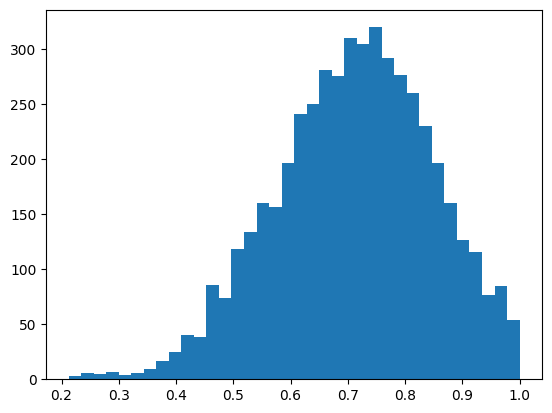

In [5]:
ax = plt.hist(newTrip.SOC_int_, bins='auto')

In [6]:
print('number of EV',len(newTrip.ev_sample))
print('number of trips',len(newTrip.ev_trip))
print('number of zones', newTrip.num_zone)

number of EV 4944
number of trips 18666
number of zones 79


In [7]:
# Charging Choice
choiceModel = ChargingChoice(newTrip)

In [8]:
print('charging rate (kW) [home L2, non_home L2, non_home DCFC]:', choiceModel.trip.rate)
print('home charging price ($):', choiceModel.trip.home_price)
print('simulation day:', choiceModel.trip.D)

charging rate (kW) [home L2, non_home L2, non_home DCFC]: [  3.6   6.2 150. ]
home charging price ($): 0.13
simulation day: 2


In [9]:
choiceModel.charging_choice_parameters()

* charging choice parameters:
beta_SOC: 3
beta_R: -0.005
beta_delta_SOC: 2
beta_0: 1
beta_SOC_0: 0.3
beta_cost: 0.1
lambda: 1
* charging choice plot parameters
not-home charging price ($): 0.43
available charging type (home, non-home L2, non_home DCFC): [0, 1, 1]


total energy of EV (kWh): 60


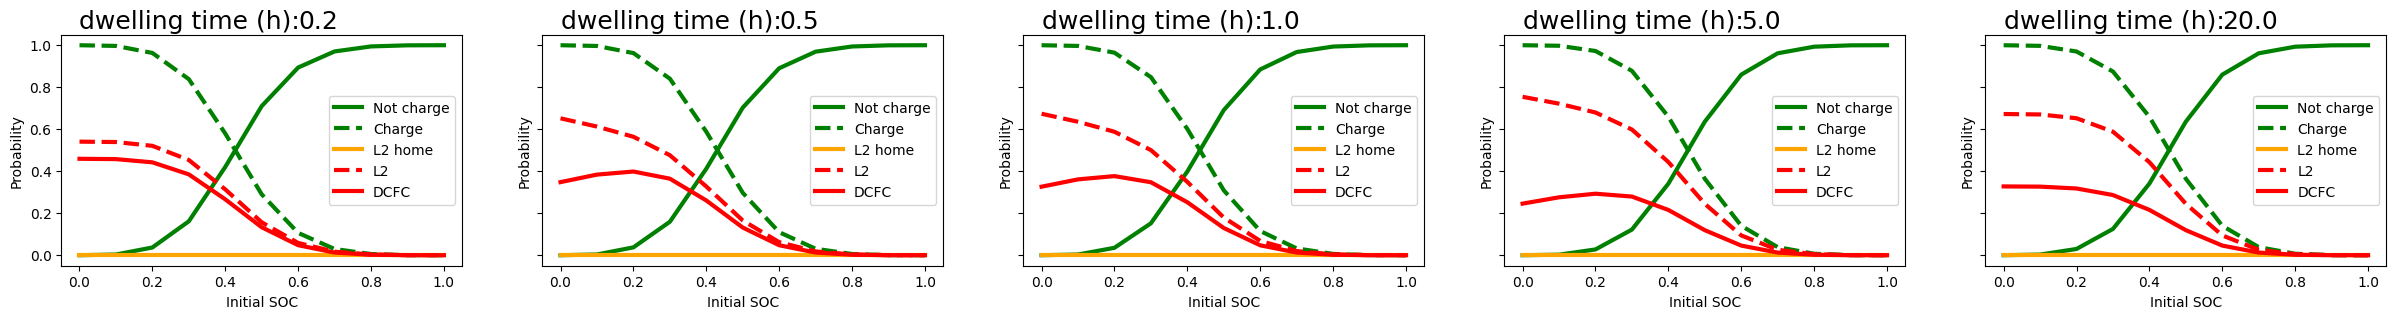

In [10]:
# total energy of EV
test_En = 60 #250 #100 # 60
print('total energy of EV (kWh):',test_En)

wait_time = np.array([0.2,0.5,1,5,20]) #([0.2,0.5,1,2,3,5,6,7,10])

fig, axs = plt.subplots(1,len(wait_time), figsize=(6*len(wait_time),3), sharey=True)

SOC_test = np.arange(0, 1.1, 0.1)

for j in range(len(wait_time)):
    z = []
    
    for i in SOC_test:
        z = z + [choiceModel.charging_choice(i,wait_time[j],test_En,L_available,test_pub_price)[1]]  

    z0 = np.array(z).T[0]
    z1 = np.array(z).T[1]
    z2 = np.array(z).T[2]
    z3 = np.array(z).T[3]
    
    axs[j].plot( SOC_test, z0, marker='', color='green', linewidth=3,linestyle='solid',label="Not charge")
    axs[j].plot( SOC_test, 1-z0, marker='', color='green', linewidth=3, linestyle='dashed',label="Charge")
    axs[j].plot( SOC_test, z1, marker='', color='orange', linewidth=3,linestyle='solid',label="L2 home")
    axs[j].plot( SOC_test, z2, marker='', color='r', linewidth=3,linestyle='dashed',label="L2")
    axs[j].plot( SOC_test, z3, marker='', color='r', linewidth=3,linestyle='solid',label="DCFC")
    axs[j].set_xlabel('Initial SOC')
    axs[j].set_ylabel('Probability')
    axs[j].text(0, 1.08, 'dwelling time (h):', fontsize=18)
    axs[j].text(0.6, 1.08, wait_time[j], fontsize=18)
    axs[j].legend(loc = 'right')

plt.subplots_adjust(hspace=0.3)

total energy of EV (kWh): 100


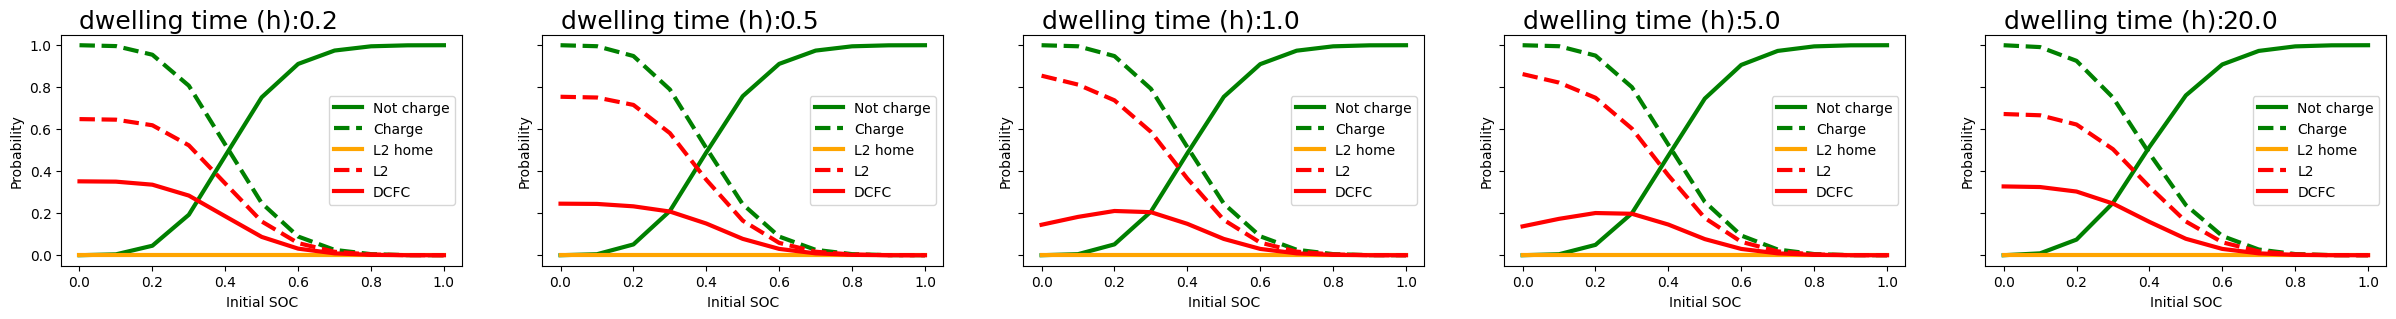

In [11]:
# total energy of EV
test_En = 100 #250 #100 # 60
print('total energy of EV (kWh):',test_En)

import matplotlib.pyplot as plt

wait_time = np.array([0.2,0.5,1,5,20]) #([0.2,0.5,1,2,3,5,6,7,10])

fig, axs = plt.subplots(1,len(wait_time), figsize=(6*len(wait_time),3), sharey=True)

SOC_test = np.arange(0, 1.1, 0.1)

for j in range(len(wait_time)):
    z = []
    
    for i in SOC_test:
        z = z + [choiceModel.charging_choice(i,wait_time[j],test_En,L_available,test_pub_price)[1]]  

    z0 = np.array(z).T[0]
    z1 = np.array(z).T[1]
    z2 = np.array(z).T[2]
    z3 = np.array(z).T[3]
    
    axs[j].plot( SOC_test, z0, marker='', color='green', linewidth=3,linestyle='solid',label="Not charge")
    axs[j].plot( SOC_test, 1-z0, marker='', color='green', linewidth=3, linestyle='dashed',label="Charge")
    axs[j].plot( SOC_test, z1, marker='', color='orange', linewidth=3,linestyle='solid',label="L2 home")
    axs[j].plot( SOC_test, z2, marker='', color='r', linewidth=3,linestyle='dashed',label="L2")
    axs[j].plot( SOC_test, z3, marker='', color='r', linewidth=3,linestyle='solid',label="DCFC")
    axs[j].set_xlabel('Initial SOC')
    axs[j].set_ylabel('Probability')
    axs[j].text(0, 1.08, 'dwelling time (h):', fontsize=18)
    axs[j].text(0.6, 1.08, wait_time[j], fontsize=18)
    axs[j].legend(loc = 'right')

plt.subplots_adjust(hspace=0.3)

In [12]:
demandModel = ChargingDemand(newTrip)

In [13]:
placementModel = ChargingPlacement(newTrip)

In [14]:
# define how to run the simulation

N_initial = 2 # N. initial points, need to be >=2
BATCH_SIZE = 1 # N. new sample points  can't be over 1, takes too long to find optimize_acqf
N_BATCH = 5 # N. iteration each trial
N_TRIALS = 2 # N. try whole algorithm

In [15]:
optimizationSolverModel = OptimizationSolvers(
    newTrip,
    low_dim=5, 
    x_l_bound=-1, 
    x_u_bound=1, 
    y_variance=0.1
)

In [16]:
new_shape = newTrip.shapefile[['new_zone_name', 'geometry']]
new_shape = new_shape.dissolve(by='new_zone_name', aggfunc='sum')
new_shape = new_shape.reset_index()


Trial  1 of 2 

/Users/richardlin/Library/CloudStorage/OneDrive-CornellUniversity/Documents/Cornell University/Spring 24/MEng Project/Etransportation_models/src/etransportmodel/optimization_solvers.py:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(rand_yy).to(self.trip.ddtype)



Trial  2 of 2 

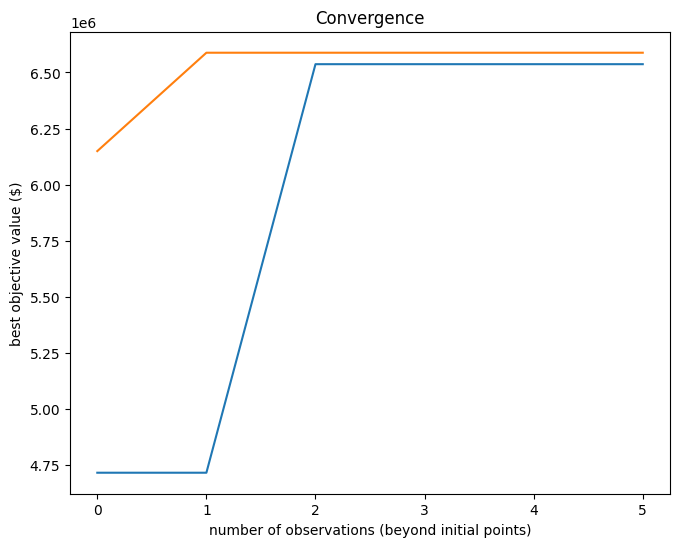

In [17]:
Run_result = optimizationSolverModel.BO_run(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS)

best_observed_all, best_observed_all_x, init_x, init_y = Run_result

iters = np.arange(len(best_observed_all_x[0])) 
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(len(best_observed_all)):
    ax = plt.plot(iters, y_value[i])

plt.title('Convergence')
#plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
#plt.savefig('converge/%sconverge_iteration.png'%pr,bbox_inches='tight')

plt.show()

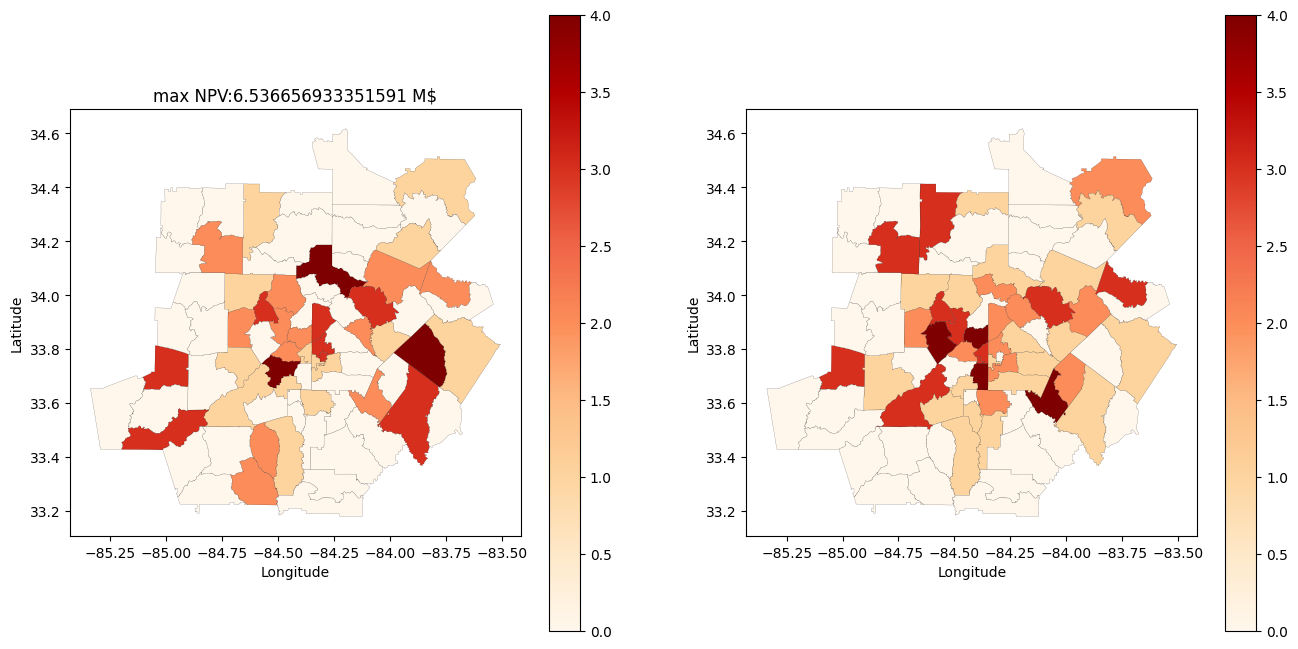

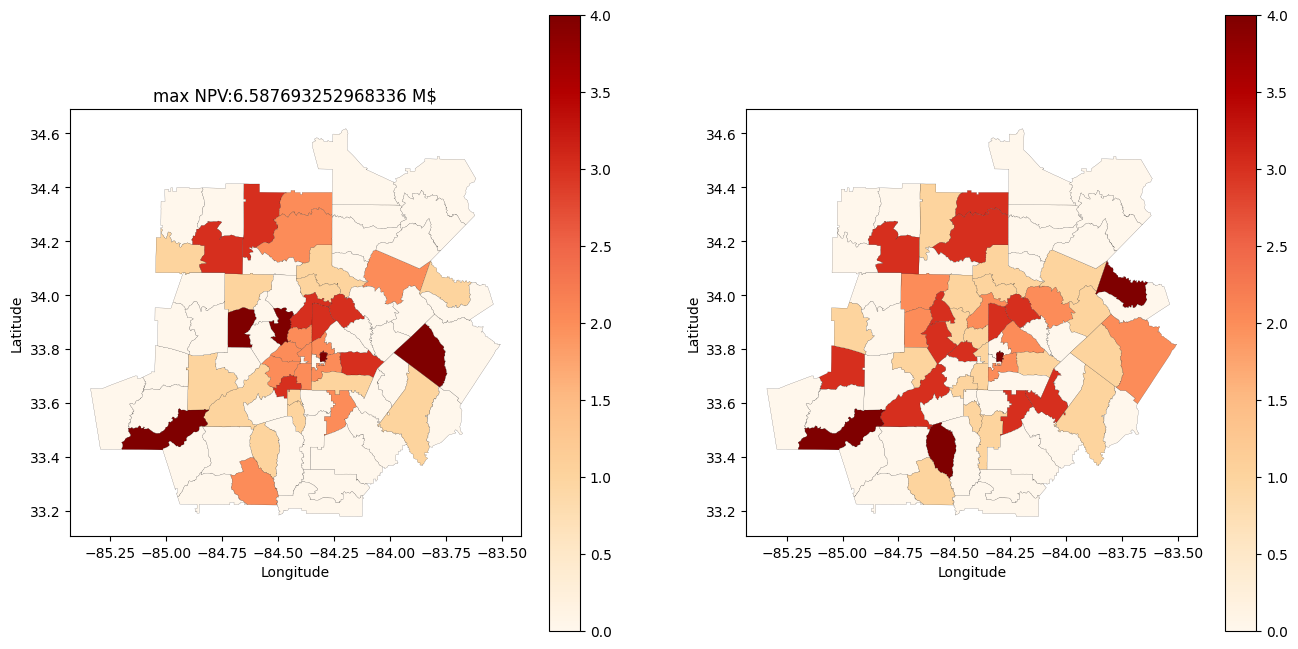

In [18]:
############# plot for BO (run only if used BO solver)

for i in range(len(best_observed_all)):
    which_trial = i # define which trail to plot
    result_x = best_observed_all_x[which_trial][N_BATCH]
    #result_x = low_to_high_dimension(A_all[i],result_x)
    result_x = torch.reshape(result_x,(2,optimizationSolverModel.trip.num_zone)).to(dtype = optimizationSolverModel.trip.ddtype).tolist()
    max_NPV = max(best_observed_all[which_trial])

    new_shape['L2'] = result_x[0]
    new_shape['DCFC'] = result_x[1]
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('float64')

    fig, ax = plt.subplots(1, 2,figsize=(16, 8))

    new_shape.plot(column='L2', ax=ax[0], legend=True,cmap='OrRd',edgecolor='black',linewidth = 0.1)


    new_shape.plot(column='DCFC', ax=ax[1], legend=True,cmap='OrRd',edgecolor='black',linewidth = 0.1)

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[0].set_title('max NPV:%s M$'%(max_NPV/10**6))
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')

#plt.savefig('best_result.png',bbox_inches='tight');



Trial  1 of 2 .....
Trial  2 of 2 .....

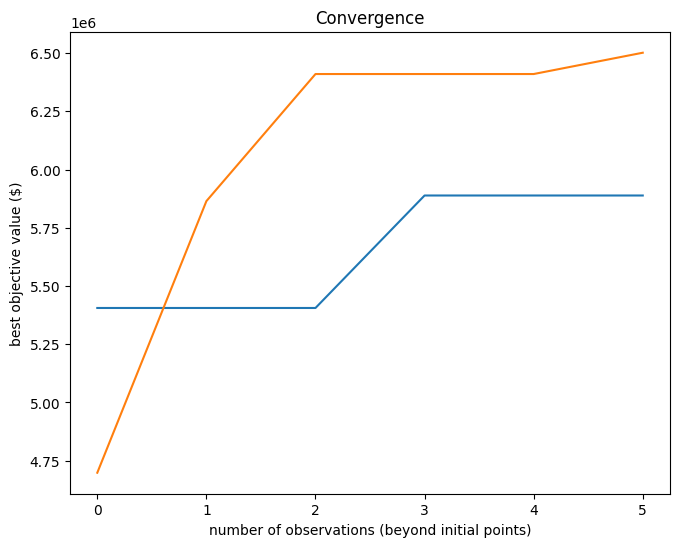

In [19]:
Run_result = optimizationSolverModel.Random_search(N_BATCH,N_TRIALS)

best_observed_all, best_observed_all_x, init_x, init_y = Run_result

iters = np.arange(len(best_observed_all_x[0])) 
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(len(best_observed_all)):
    ax = plt.plot(iters, y_value[i])

plt.title('Convergence')
#plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
#plt.savefig('converge/%sconverge_iteration.png'%pr,bbox_inches='tight')

plt.show()


Trial  1 of 2 
Trial  2 of 2 

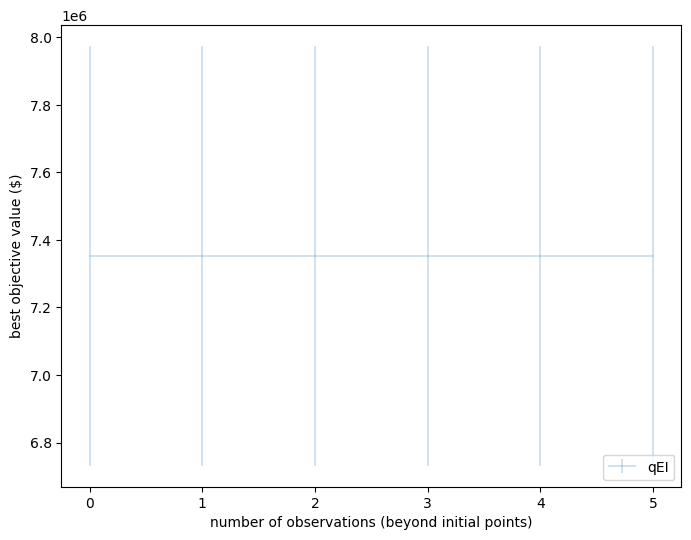

In [20]:
Run_result = optimizationSolverModel.REMBO_run(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS)

best_observed_all, best_observed_all_x, init_x, init_y, A_all = Run_result

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(len(best_observed_all))

iters = np.arange(len(best_observed_all_x[0]))
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_value.mean(axis=0), yerr=ci(y_value), label="qEI", linewidth=0.3)
#ax.set_ylim(bottom=5500000)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value ($)')
ax.legend(loc="lower right")



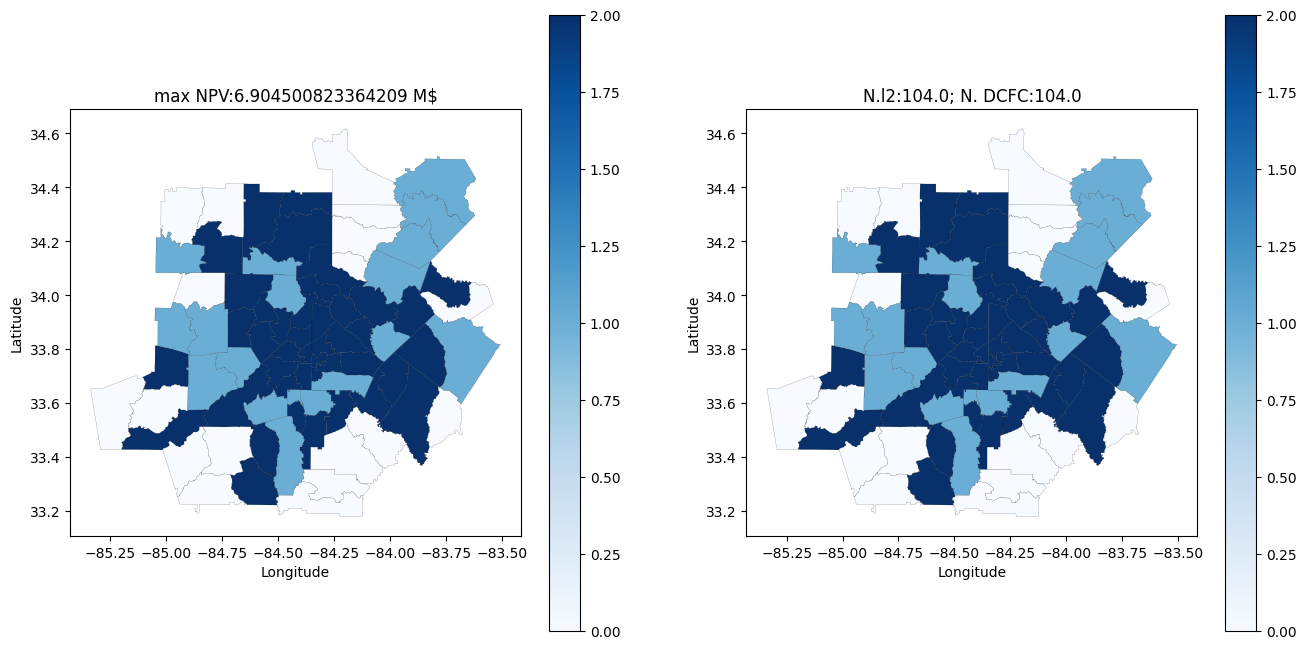

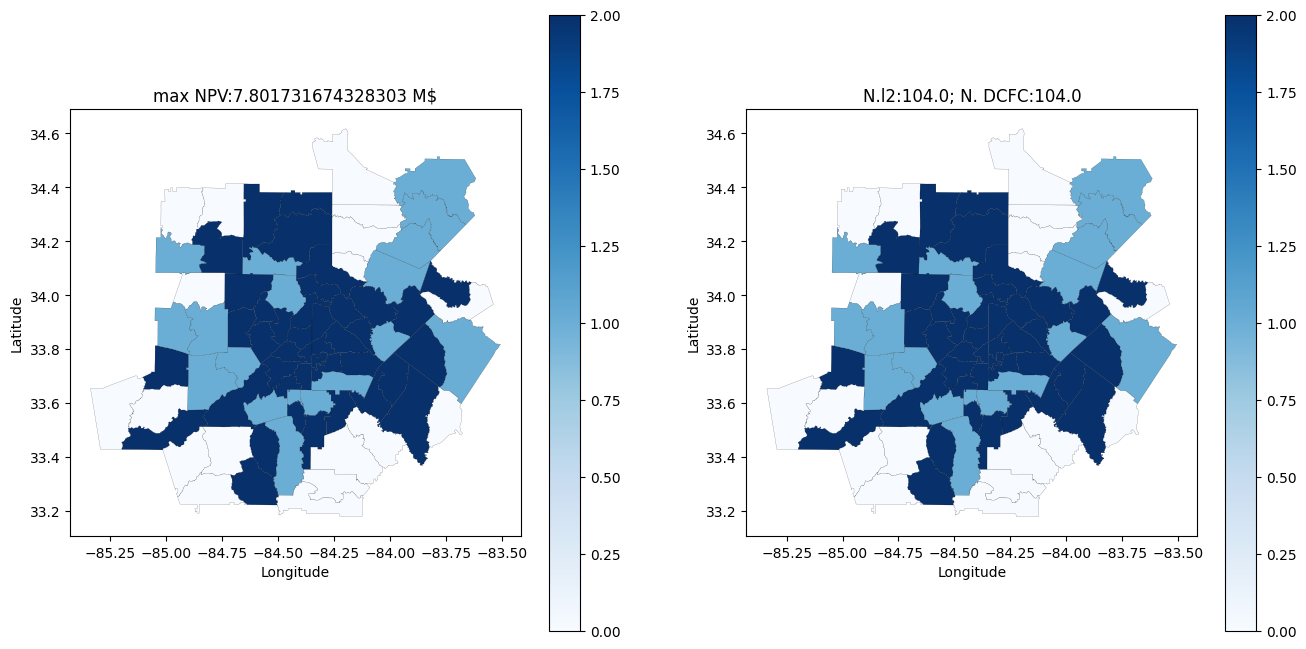

In [21]:
############# plot for REMBO (run only if used REMBO solver)

for i in range(len(best_observed_all)):
    which_trial = i # define which trail to plot
    result_x = best_observed_all_x[which_trial][len(best_observed_all_x[0])-1]
    result_x = torch.clamp(optimizationSolverModel.low_to_high_dimension(A_all[i],result_x), min=0, max=None) 
    result_x = torch.reshape(result_x,(2,optimizationSolverModel.trip.num_zone)).to(dtype = optimizationSolverModel.trip.ddtype).tolist()
    max_NPV = max(best_observed_all[which_trial])

    new_shape['L2'] = result_x[0]
    new_shape['DCFC'] = result_x[1]
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('float64')

    fig, ax = plt.subplots(1, 2,figsize=(16, 8))

    new_shape.plot(column='L2', ax=ax[0], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)


    new_shape.plot(column='DCFC', ax=ax[1], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[0].set_title('max NPV:%s M$'%(max_NPV/10**6))
    ax[1].set_title('N.l2:%s; N. DCFC:%s'%(sum(result_x[0]),sum(result_x[1])))
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')
